#  CIFAR-10 Image Classification: Standard CNN vs Depthwise Separable Convolutions



- Building a **Standard CNN** (baseline) and a **Depthwise Separable CNN**
- Comparing parameter counts and FLOPs between both architectures
- Training both models and evaluating on the test set
- Reporting **Accuracy, Precision, Recall, F1-Score** and the **Confusion Matrix**
- Hyperparameter tuning via **Grid Search** and **Optuna** (3 hyperparams × 3 values each)

**Priyadip Sau(M25CSA023)**

## Environment Setup & Imports

Before anything else, we install `optuna` for Bayesian hyperparameter optimization and `torchinfo` for neat model summaries. Everything else ships with Colab by default.

In [ ]:
!pip install optuna torchinfo -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 11.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import optuna
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings('ignore')

# ---- Device Configuration ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


##  Data Loading & Preprocessing



In [ ]:
# ---- CIFAR-10 class names ----
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# ---- Transforms ----
# Channel-wise statistics for CIFAR-10
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

# ---- Download and load datasets ----
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

print(f"Training samples : {len(train_dataset)}")
print(f"Test samples     : {len(test_dataset)}")
print(f"Image shape      : {train_dataset[0][0].shape}")
print(f"Number of classes : {len(CIFAR10_CLASSES)}")

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Training samples : 50000
Test samples     : 10000
Image shape      : torch.Size([3, 32, 32])
Number of classes : 10


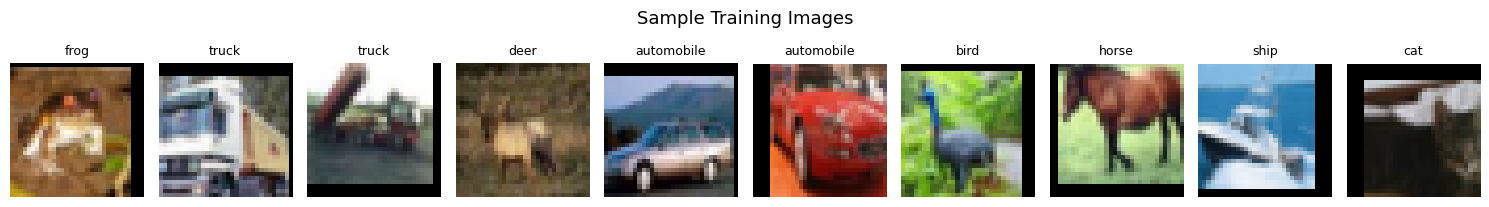

In [ ]:
# ---- Visualize some training samples ----
def show_samples(dataset, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 2))
    for i in range(n):
        img, label = dataset[i]
        # Undo normalization for display
        img = img.clone()
        for ch in range(3):
            img[ch] = img[ch] * cifar_std[ch] + cifar_mean[ch]
        img = img.clamp(0, 1)
        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].set_title(CIFAR10_CLASSES[label], fontsize=9)
        axes[i].axis('off')
    plt.suptitle('Sample Training Images', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

##  Model Architectures

We construct two architecturally analogous CNNs. The **Standard CNN** uses regular `Conv2d` layers throughout, while the **Depthwise Separable CNN** replaces at least two of those convolution blocks with a depthwise convolution (`groups=C_in`) followed by a pointwise 1×1 convolution.

A standard convolution on an input of size $C_{in} \times H \times W$ with kernel $K \times K$ producing $C_{out}$ feature maps has:
$$\text{Params}_{\text{std}} = C_{out} \times (C_{in} \times K^2 + 1)$$

The depthwise separable variant instead costs:
$$\text{Params}_{\text{DW+PW}} = C_{in} \times (K^2 + 1) + C_{out} \times (C_{in} + 1)$$

When $C_{out}$ is large — and it almost always is — the savings can be substantial.

In [ ]:

#  Depthwise Separable Convolution Block

class DepthwiseSeparableConv(nn.Module):
    """
    Depthwise convolution (spatial filtering per channel)
    followed by pointwise 1x1 convolution (cross-channel mixing).
    This factorization dramatically reduces parameter count.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise: groups = in_channels => each channel gets its own filter
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=in_channels, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        # Pointwise: 1x1 conv to combine channels
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.depthwise(x)))
        x = F.relu(self.bn2(self.pointwise(x)))
        return x

In [ ]:

#  Standard CNN

class StandardCNN(nn.Module):
    """
    A straightforward convolutional network with 4 conv blocks,
    each using standard Conv2d + BatchNorm + ReLU, followed by
    max-pooling and a fully connected classifier head.
    """
    def __init__(self, num_classes=10, dropout_rate=0.25):
        super(StandardCNN, self).__init__()

        # Block 1: 3 -> 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)

        # Block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(64)

        # Block 3: 64 -> 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(128)

        # Block 4: 128 -> 256
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
        self.bn4   = nn.BatchNorm2d(256)

        self.pool    = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # After 4 pools: 32 -> 16 -> 8 -> 4 -> 2, so 256 * 2 * 2 = 1024
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # 32x32 -> 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # 16x16 -> 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # 8x8   -> 4x4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))   # 4x4   -> 2x2
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:

#  Depthwise Separable CNN

class DepthwiseSeparableCNN(nn.Module):
    """
    Same overall topology as StandardCNN, but blocks 2 and 3
    (at minimum) are replaced with depthwise separable convolutions.
    In practice we replace blocks 2, 3, AND 4 to really push the
    parameter savings, while keeping block 1 as standard convolutions.
    """
    def __init__(self, num_classes=10, dropout_rate=0.25):
        super(DepthwiseSeparableCNN, self).__init__()

        # Block 1: standard conv (3 input channels — not worth separating)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)

        # Blocks 2, 3, 4: depthwise separable convolutions
        self.dw_conv2 = DepthwiseSeparableConv(32,  64,  kernel_size=3, padding=1)
        self.dw_conv3 = DepthwiseSeparableConv(64,  128, kernel_size=3, padding=1)
        self.dw_conv4 = DepthwiseSeparableConv(128, 256, kernel_size=3, padding=1)

        self.pool    = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Standard conv
        x = self.pool(self.dw_conv2(x))                  # DW Separable
        x = self.pool(self.dw_conv3(x))                  # DW Separable
        x = self.pool(self.dw_conv4(x))                  # DW Separable
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## Parameter Count & Computational Efficiency Comparison
- Print  summaries using `torchinfo`,


In [ ]:
# ---- Instantiate both models ----
std_model = StandardCNN(num_classes=10).to(device)
dw_model  = DepthwiseSeparableCNN(num_classes=10).to(device)


print("STANDARD CNN  Model Summary")

summary(std_model, input_size=(1, 3, 32, 32), col_names=["output_size", "num_params", "mult_adds"])


print("DEPTHWISE SEPARABLE CNN  Model Summary")

summary(dw_model, input_size=(1, 3, 32, 32), col_names=["output_size", "num_params", "mult_adds"])

STANDARD CNN  Model Summary
DEPTHWISE SEPARABLE CNN  Model Summary


Layer (type:depth-idx)                   Output Shape              Param #                   Mult-Adds
DepthwiseSeparableCNN                    [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 32, 32, 32]           864                       884,736
├─BatchNorm2d: 1-2                       [1, 32, 32, 32]           64                        64
├─MaxPool2d: 1-3                         [1, 32, 16, 16]           --                        --
├─DepthwiseSeparableConv: 1-4            [1, 64, 16, 16]           --                        --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           288                       73,728
│    └─BatchNorm2d: 2-2                  [1, 32, 16, 16]           64                        64
│    └─Conv2d: 2-3                       [1, 64, 16, 16]           2,048                     524,288
│    └─BatchNorm2d: 2-4                  [1, 64, 16, 16]           128                       128
├─MaxPool2d: 1-5  

In [ ]:
# ----  parameter comparison ----
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

std_params = count_parameters(std_model)
dw_params  = count_parameters(dw_model)
reduction  = (1 - dw_params / std_params) * 100

print(f"Standard CNN parameters       : {std_params:>10,}")
print(f"Depthwise Separable CNN params : {dw_params:>10,}")
print(f"Parameter reduction            : {reduction:.2f}%")
print(f"Compression ratio              : {std_params / dw_params:.2f}x")

Standard CNN parameters       :    918,826
Depthwise Separable CNN params :    577,226
Parameter reduction            : 37.18%
Compression ratio              : 1.59x


In [ ]:
# ---- Inference speed comparison ----
def benchmark_inference(model, input_shape=(64, 3, 32, 32), n_runs=100):
    model.eval()
    dummy = torch.randn(*input_shape).to(device)
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(dummy)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    elapsed = (time.time() - start) / n_runs * 1000  # ms per batch
    return elapsed

std_time = benchmark_inference(std_model)
dw_time  = benchmark_inference(dw_model)

print(f"Standard CNN — Avg inference time   : {std_time:.2f} ms/batch")
print(f"DW Separable CNN — Avg inference time: {dw_time:.2f} ms/batch")
print(f"Speedup factor: {std_time / dw_time:.2f}x")

Standard CNN — Avg inference time   : 1.28 ms/batch
DW Separable CNN — Avg inference time: 1.16 ms/batch
Speedup factor: 1.10x


##  Training & Evaluation Utilities

We define reusable functions for training loops and evaluation. The training function tracks per-epoch loss and accuracy, while the evaluation function collects all predictions to compute the full suite of sklearn metrics downstream.

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for a single epoch; returns average loss and accuracy."""
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total   += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc  = 100.0 * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader):
    """Evaluate the model; returns loss, accuracy, all preds, all labels."""
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total   += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss = running_loss / total
    acc  = 100.0 * correct / total
    return loss, acc, np.array(all_preds), np.array(all_labels)


def train_model(model, train_loader, test_loader, epochs=20,
                lr=0.001, weight_decay=1e-4, scheduler_type='cosine'):
    """
    Full training loop with scheduler. Returns history dict
    and the trained model.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    if scheduler_type == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    elif scheduler_type == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    else:
        scheduler = None

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        test_loss, test_acc, _, _ = evaluate(model, test_loader)

        if scheduler:
            scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        if epoch % 5 == 0 or epoch == 1:
            print(f"  Epoch [{epoch:>2}/{epochs}]  "
                  f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%  "
                  f"Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.2f}%")

    return model, history

##  Training Both Models

Train both the standard CNN and the depthwise separable variant for 25 epochs with identical hyperparameters.

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 25
LEARNING_RATE = 0.001

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

# Re-initialize models fresh
std_model = StandardCNN(num_classes=10).to(device)
dw_model  = DepthwiseSeparableCNN(num_classes=10).to(device)


print("  Training STANDARD CNN")

std_model, std_history = train_model(
    std_model, train_loader, test_loader,
    epochs=NUM_EPOCHS, lr=LEARNING_RATE
)


print("  Training DEPTHWISE SEPARABLE CNN")

dw_model, dw_history = train_model(
    dw_model, train_loader, test_loader,
    epochs=NUM_EPOCHS, lr=LEARNING_RATE
)

  Training STANDARD CNN
  Epoch [ 1/25]  Train Loss: 1.4109  Train Acc: 48.20%  Test Loss: 1.0686  Test Acc: 62.17%
  Epoch [ 5/25]  Train Loss: 0.7210  Train Acc: 74.80%  Test Loss: 0.6955  Test Acc: 75.61%
  Epoch [10/25]  Train Loss: 0.5378  Train Acc: 81.07%  Test Loss: 0.5675  Test Acc: 80.58%
  Epoch [15/25]  Train Loss: 0.4198  Train Acc: 85.43%  Test Loss: 0.4657  Test Acc: 83.89%
  Epoch [20/25]  Train Loss: 0.3343  Train Acc: 88.20%  Test Loss: 0.4287  Test Acc: 85.36%
  Epoch [25/25]  Train Loss: 0.2949  Train Acc: 89.82%  Test Loss: 0.4114  Test Acc: 86.35%
  Training DEPTHWISE SEPARABLE CNN
  Epoch [ 1/25]  Train Loss: 1.5301  Train Acc: 43.50%  Test Loss: 1.2372  Test Acc: 55.24%
  Epoch [ 5/25]  Train Loss: 0.9511  Train Acc: 66.23%  Test Loss: 0.8870  Test Acc: 68.18%
  Epoch [10/25]  Train Loss: 0.7678  Train Acc: 73.13%  Test Loss: 0.7360  Test Acc: 73.99%
  Epoch [15/25]  Train Loss: 0.6699  Train Acc: 76.41%  Test Loss: 0.6688  Test Acc: 76.95%
  Epoch [20/25]  Trai

##  Training Curves  

Plotting loss and accuracy curve side to see convergence behavior.

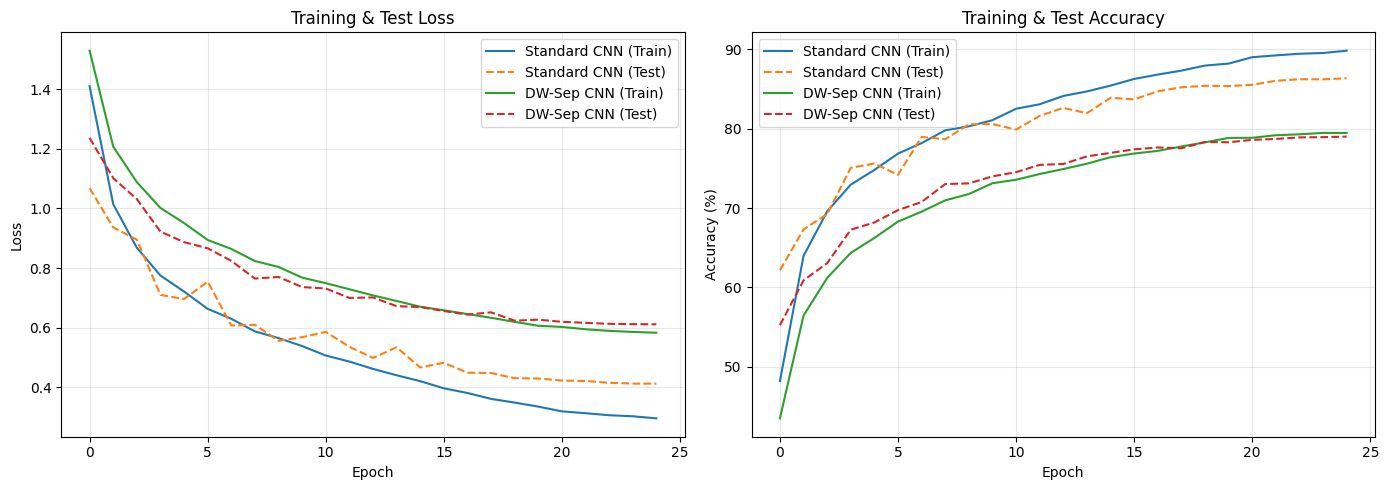

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(std_history['train_loss'], label='Standard CNN (Train)', linestyle='-')
axes[0].plot(std_history['test_loss'],  label='Standard CNN (Test)',  linestyle='--')
axes[0].plot(dw_history['train_loss'],  label='DW-Sep CNN (Train)',   linestyle='-')
axes[0].plot(dw_history['test_loss'],   label='DW-Sep CNN (Test)',    linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(std_history['train_acc'], label='Standard CNN (Train)', linestyle='-')
axes[1].plot(std_history['test_acc'],  label='Standard CNN (Test)',  linestyle='--')
axes[1].plot(dw_history['train_acc'],  label='DW-Sep CNN (Train)',   linestyle='-')
axes[1].plot(dw_history['test_acc'],   label='DW-Sep CNN (Test)',    linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training & Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Performance Metrics & Confusion Matrix

Raw accuracy alone can be misleading - especially on slightly imbalanced partitions or when per-class performance varies wildly. So we report all the metric: weighted Precision, Recall, F1-Score, plus class-wise breakdowns and a confusion matrix heatmap.

In [ ]:
def full_evaluation(model, loader, model_name="Model"):
    """
    Run evaluation, print metrics, plot confusion matrix.
    Returns the metrics dict for later comparison.
    """
    _, acc, preds, labels = evaluate(model, loader)

    accuracy  = accuracy_score(labels, preds) * 100
    precision = precision_score(labels, preds, average='weighted') * 100
    recall    = recall_score(labels, preds, average='weighted') * 100
    f1        = f1_score(labels, preds, average='weighted') * 100

    print(f"\n{'=' * 60}")
    print(f"  {model_name} — Test Set Performance")
    print(f"{'=' * 60}")
    print(f"  Accuracy  : {accuracy:.2f}%")
    print(f"  Precision : {precision:.2f}%  (weighted)")
    print(f"  Recall    : {recall:.2f}%  (weighted)")
    print(f"  F1-Score  : {f1:.2f}%  (weighted)")
    print(f"\n--- Class-wise Report ---")
    print(classification_report(labels, preds, target_names=CIFAR10_CLASSES, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CIFAR10_CLASSES,
                yticklabels=CIFAR10_CLASSES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix — {model_name}')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy, 'precision': precision,
        'recall': recall, 'f1_score': f1
    }


  Standard CNN — Test Set Performance
  Accuracy  : 86.35%
  Precision : 86.28%  (weighted)
  Recall    : 86.35%  (weighted)
  F1-Score  : 86.30%  (weighted)

--- Class-wise Report ---
              precision    recall  f1-score   support

    airplane     0.8600    0.8910    0.8752      1000
  automobile     0.9392    0.9430    0.9411      1000
        bird     0.8401    0.8090    0.8242      1000
         cat     0.7357    0.6960    0.7153      1000
        deer     0.8378    0.8680    0.8527      1000
         dog     0.7869    0.7900    0.7884      1000
        frog     0.8911    0.9000    0.8955      1000
       horse     0.9050    0.8860    0.8954      1000
        ship     0.9227    0.9310    0.9268      1000
       truck     0.9092    0.9210    0.9151      1000

    accuracy                         0.8635     10000
   macro avg     0.8628    0.8635    0.8630     10000
weighted avg     0.8628    0.8635    0.8630     10000



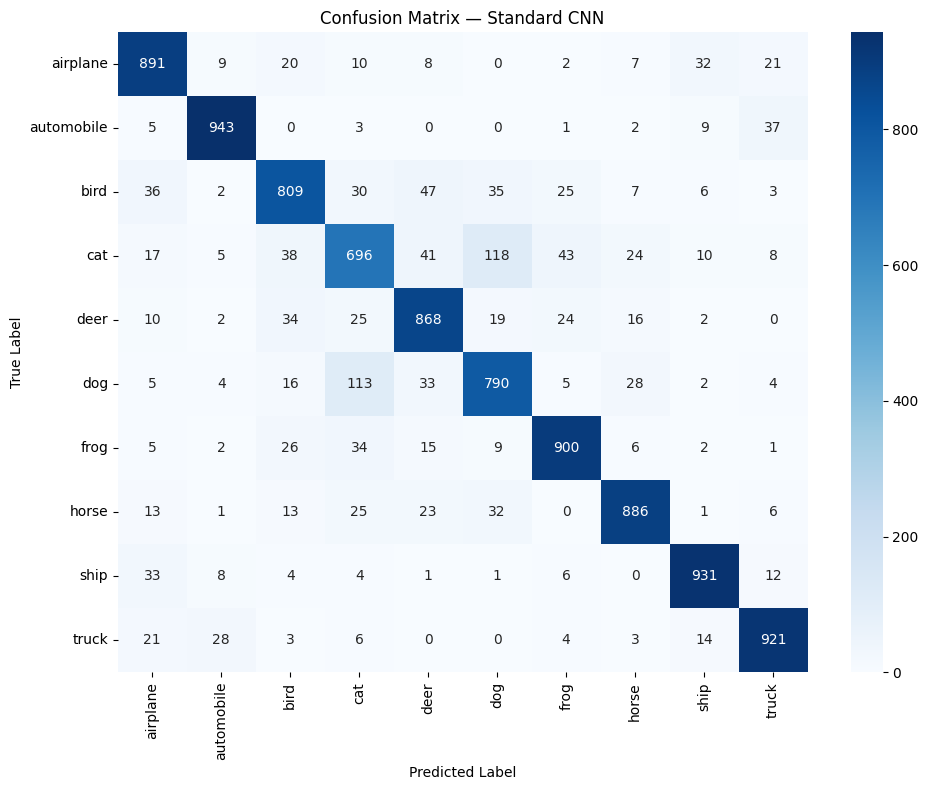

In [ ]:
std_metrics = full_evaluation(std_model, test_loader, "Standard CNN")


  Depthwise Separable CNN — Test Set Performance
  Accuracy  : 79.00%
  Precision : 78.83%  (weighted)
  Recall    : 79.00%  (weighted)
  F1-Score  : 78.87%  (weighted)

--- Class-wise Report ---
              precision    recall  f1-score   support

    airplane     0.7927    0.7990    0.7958      1000
  automobile     0.8882    0.8660    0.8770      1000
        bird     0.7322    0.6890    0.7099      1000
         cat     0.6656    0.5990    0.6305      1000
        deer     0.7652    0.7820    0.7735      1000
         dog     0.7043    0.7120    0.7081      1000
        frog     0.8026    0.8540    0.8275      1000
       horse     0.8352    0.8260    0.8306      1000
        ship     0.8638    0.8880    0.8757      1000
       truck     0.8333    0.8850    0.8584      1000

    accuracy                         0.7900     10000
   macro avg     0.7883    0.7900    0.7887     10000
weighted avg     0.7883    0.7900    0.7887     10000



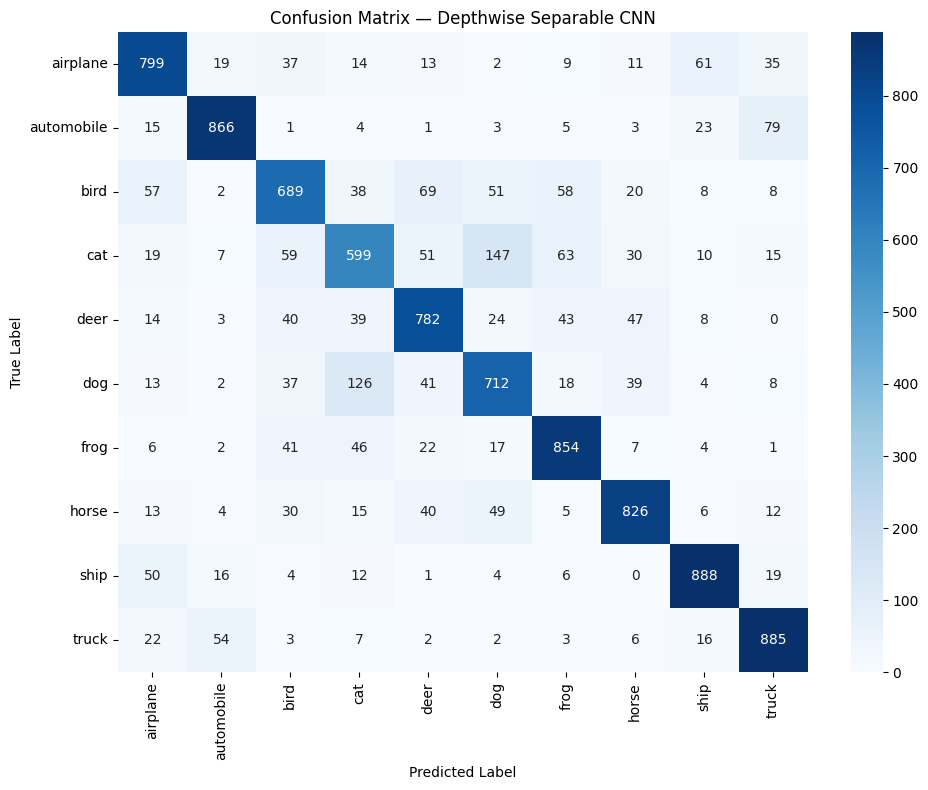

In [ ]:
dw_metrics = full_evaluation(dw_model, test_loader, "Depthwise Separable CNN")

In [ ]:
# ----  summary table ----

print(f"{'Metric':<20} {'Standard CNN':>18} {'DW-Sep CNN':>18}")
print(f"{'Parameters':<20} {std_params:>18,} {dw_params:>18,}")
print(f"{'Accuracy (%)':<20} {std_metrics['accuracy']:>18.2f} {dw_metrics['accuracy']:>18.2f}")
print(f"{'Precision (%)':<20} {std_metrics['precision']:>18.2f} {dw_metrics['precision']:>18.2f}")
print(f"{'Recall (%)':<20} {std_metrics['recall']:>18.2f} {dw_metrics['recall']:>18.2f}")
print(f"{'F1-Score (%)':<20} {std_metrics['f1_score']:>18.2f} {dw_metrics['f1_score']:>18.2f}")
print(f"{'Inference (ms)':<20} {std_time:>18.2f} {dw_time:>18.2f}")


Metric                     Standard CNN         DW-Sep CNN
Parameters                      918,826            577,226
Accuracy (%)                      86.35              79.00
Precision (%)                     86.28              78.83
Recall (%)                        86.35              79.00
F1-Score (%)                      86.30              78.87
Inference (ms)                     1.28               1.16


## 9. Hyperparameter Tuning  Grid Search

A systematic **Grid Search** over three hyperparameters, each sampled at three distinct levels:

| Hyperparameter   | Values                        |
|------------------|-------------------------------|
| Learning Rate    | 0.0005, 0.001, 0.005          |
| Batch Size       | 64, 128, 256                  |
| Dropout Rate     | 0.1, 0.25, 0.5                |

That's $3^3 = 27$ configurations total.

In [ ]:
# ---- Grid Search Configuration ----
GRID_EPOCHS = 10  # Reduced epochs for speed during the sweep

param_grid = {
    'lr':           [0.0005, 0.001, 0.005],
    'batch_size':   [64, 128, 256],
    'dropout_rate': [0.1, 0.25, 0.5],
}

# Generate all 27 combinations
keys = list(param_grid.keys())
combos = list(itertools.product(*param_grid.values()))
print(f"Total Grid Search configurations: {len(combos)}")

grid_results = []

for idx, (lr, bs, dropout) in enumerate(combos, 1):
    print(f"\n[{idx:>2}/{len(combos)}] lr={lr}, batch_size={bs}, dropout={dropout}")

    # Build data loaders with this batch size
    gs_train_loader = DataLoader(train_dataset, batch_size=bs,
                                shuffle=True, num_workers=2, pin_memory=True)
    gs_test_loader  = DataLoader(test_dataset, batch_size=bs,
                                shuffle=False, num_workers=2, pin_memory=True)

    # Fresh model with specified dropout
    gs_model = DepthwiseSeparableCNN(num_classes=10, dropout_rate=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(gs_model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=GRID_EPOCHS)

    # Quick training
    for epoch in range(GRID_EPOCHS):
        train_one_epoch(gs_model, gs_train_loader, criterion, optimizer)
        scheduler.step()

    # Evaluate
    _, test_acc, preds, labels = evaluate(gs_model, gs_test_loader)
    f1 = f1_score(labels, preds, average='weighted') * 100

    grid_results.append({
        'lr': lr, 'batch_size': bs, 'dropout_rate': dropout,
        'test_acc': test_acc, 'f1_score': f1
    })
    print(f"       => Test Acc: {test_acc:.2f}%  |  F1: {f1:.2f}%")

    # Clean up GPU memory
    del gs_model, optimizer, scheduler
    torch.cuda.empty_cache()

# ---- Find best configuration ----
best_grid = max(grid_results, key=lambda x: x['test_acc'])

print("GRID SEARCH — Best Configuration")

for k, v in best_grid.items():
    print(f"  {k:<15}: {v}")

Total Grid Search configurations: 27

[ 1/27] lr=0.0005, batch_size=64, dropout=0.1
       => Test Acc: 71.78%  |  F1: 71.55%

[ 2/27] lr=0.0005, batch_size=64, dropout=0.25
       => Test Acc: 70.83%  |  F1: 70.67%

[ 3/27] lr=0.0005, batch_size=64, dropout=0.5
       => Test Acc: 70.54%  |  F1: 70.48%

[ 4/27] lr=0.0005, batch_size=128, dropout=0.1
       => Test Acc: 69.26%  |  F1: 69.14%

[ 5/27] lr=0.0005, batch_size=128, dropout=0.25
       => Test Acc: 69.33%  |  F1: 69.21%

[ 6/27] lr=0.0005, batch_size=128, dropout=0.5
       => Test Acc: 66.68%  |  F1: 66.48%

[ 7/27] lr=0.0005, batch_size=256, dropout=0.1
       => Test Acc: 65.64%  |  F1: 65.40%

[ 8/27] lr=0.0005, batch_size=256, dropout=0.25
       => Test Acc: 65.21%  |  F1: 64.93%

[ 9/27] lr=0.0005, batch_size=256, dropout=0.5
       => Test Acc: 63.40%  |  F1: 63.24%

[10/27] lr=0.001, batch_size=64, dropout=0.1
       => Test Acc: 75.13%  |  F1: 74.97%

[11/27] lr=0.001, batch_size=64, dropout=0.25
       => Test Acc


Top 10 Grid Search Results:
   lr  batch_size  dropout_rate  test_acc  f1_score
0.005         128          0.10     77.47 77.347241
0.005          64          0.25     77.40 77.185366
0.005          64          0.10     77.30 77.258260
0.005         128          0.25     75.50 75.312933
0.005         128          0.50     75.34 75.122547
0.005          64          0.50     75.16 75.055500
0.001          64          0.10     75.13 74.971851
0.005         256          0.10     75.04 74.874301
0.001          64          0.25     73.94 73.833236
0.005         256          0.25     73.75 73.570256


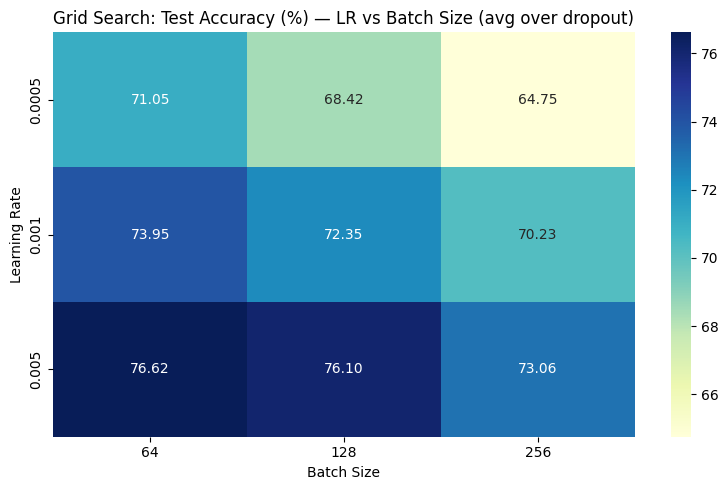

In [ ]:
# ---- Visualize Grid Search Results ----
import pandas as pd

gs_df = pd.DataFrame(grid_results)
gs_df = gs_df.sort_values('test_acc', ascending=False).reset_index(drop=True)

print("\nTop 10 Grid Search Results:")
print(gs_df.head(10).to_string(index=False))

# Heatmap: LR vs Batch Size (averaged over dropout)
pivot = gs_df.pivot_table(values='test_acc', index='lr', columns='batch_size', aggfunc='mean')
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Grid Search: Test Accuracy (%) — LR vs Batch Size (avg over dropout)')
plt.ylabel('Learning Rate')
plt.xlabel('Batch Size')
plt.tight_layout()
plt.show()

##  Hyperparameter Tuning - Optuna (Bayesian Optimization)

Grid search is exhaustive but expensive; Optuna uses Bayesian approach using the Tree-structured Parzen Estimator (TPE). It prunes unpromising trials early and focuses the sampling budget on regions that look promising. We search over the **same three hyperparameters** and their ranges.


In [ ]:
OPTUNA_EPOCHS = 10
N_TRIALS = 30  # comparable budget to grid search's 27

def optuna_objective(trial):
    """
    Objective function for Optuna. Suggests hyperparameters,
    trains the DW-Sep CNN, and returns test accuracy for
    maximization.
    """
    # ---- Suggest hyperparameters (same 3 as grid search) ----
    lr      = trial.suggest_categorical('lr', [0.0005, 0.001, 0.005])
    bs      = trial.suggest_categorical('batch_size', [64, 128, 256])
    dropout = trial.suggest_categorical('dropout_rate', [0.1, 0.25, 0.5])

    # Data loaders
    opt_train_loader = DataLoader(train_dataset, batch_size=bs,
                                 shuffle=True, num_workers=2, pin_memory=True)
    opt_test_loader  = DataLoader(test_dataset, batch_size=bs,
                                 shuffle=False, num_workers=2, pin_memory=True)

    # Model
    model     = DepthwiseSeparableCNN(num_classes=10, dropout_rate=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=OPTUNA_EPOCHS)

    # Training loop with pruning support
    for epoch in range(OPTUNA_EPOCHS):
        train_one_epoch(model, opt_train_loader, criterion, optimizer)
        scheduler.step()

        # Report intermediate value for pruning
        _, test_acc, _, _ = evaluate(model, opt_test_loader)
        trial.report(test_acc, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

    # Cleanup
    del model, optimizer, scheduler
    torch.cuda.empty_cache()

    return test_acc


# ---- Run Optuna study ----
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)

print(f"Starting Optuna optimization ({N_TRIALS} trials)...\n")
study.optimize(optuna_objective, n_trials=N_TRIALS, show_progress_bar=True)


print("OPTUNA — Best Trial")

print(f"  Best Test Accuracy : {study.best_value:.2f}%")
print(f"  Best Hyperparams   :")
for k, v in study.best_params.items():
    print(f"    {k:<15}: {v}")

Starting Optuna optimization (30 trials)...



  0%|          | 0/30 [00:00<?, ?it/s]

OPTUNA — Best Trial
  Best Test Accuracy : 78.41%
  Best Hyperparams   :
    lr             : 0.005
    batch_size     : 128
    dropout_rate   : 0.1


###Both give the same hyperparameter, but for the runtime difference, maybe we get slightly difference in Accuracy.

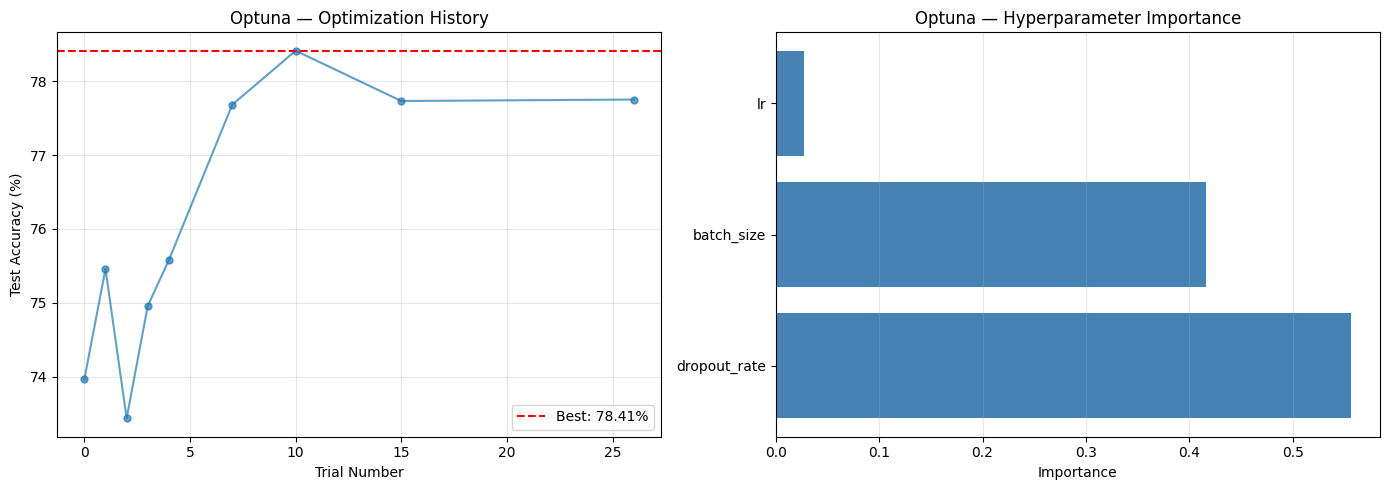

In [ ]:
# ---- Optuna Visualization ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Optimization history
trials_df = study.trials_dataframe()
completed = trials_df[trials_df['state'] == 'COMPLETE']

axes[0].plot(completed['number'], completed['value'], 'o-', alpha=0.7, markersize=5)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.2f}%')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Optuna — Optimization History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Hyperparameter importances
importances = optuna.importance.get_param_importances(study)
axes[1].barh(list(importances.keys()), list(importances.values()), color='steelblue')
axes[1].set_xlabel('Importance')
axes[1].set_title('Optuna — Hyperparameter Importance')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

##  Final Model  Retrain with Best Hyperparameters
retrain the Depthwise Separable CNN with the best hyperparameters

In [ ]:
# ---- Use the best params from Optuna (generally more efficient) ----
best_lr      = study.best_params['lr']
best_bs      = study.best_params['batch_size']
best_dropout = study.best_params['dropout_rate']

print(f"Retraining with: lr={best_lr}, batch_size={best_bs}, dropout={best_dropout}")
print(f"Training for {NUM_EPOCHS} epochs...\n")

final_train_loader = DataLoader(train_dataset, batch_size=best_bs,
                                shuffle=True, num_workers=2, pin_memory=True)
final_test_loader  = DataLoader(test_dataset, batch_size=best_bs,
                                shuffle=False, num_workers=2, pin_memory=True)

final_model = DepthwiseSeparableCNN(num_classes=10, dropout_rate=best_dropout).to(device)
final_model, final_history = train_model(
    final_model, final_train_loader, final_test_loader,
    epochs=NUM_EPOCHS, lr=best_lr
)

Retraining with: lr=0.005, batch_size=128, dropout=0.1
Training for 25 epochs...

  Epoch [ 1/25]  Train Loss: 1.6024  Train Acc: 42.18%  Test Loss: 1.2476  Test Acc: 53.48%
  Epoch [ 5/25]  Train Loss: 0.8994  Train Acc: 68.49%  Test Loss: 0.8227  Test Acc: 70.91%
  Epoch [10/25]  Train Loss: 0.7097  Train Acc: 75.32%  Test Loss: 0.6764  Test Acc: 76.83%
  Epoch [15/25]  Train Loss: 0.5951  Train Acc: 79.30%  Test Loss: 0.6165  Test Acc: 78.38%
  Epoch [20/25]  Train Loss: 0.5049  Train Acc: 82.50%  Test Loss: 0.5380  Test Acc: 81.61%
  Epoch [25/25]  Train Loss: 0.4674  Train Acc: 83.81%  Test Loss: 0.5210  Test Acc: 82.12%



  Final Tuned DW-Sep CNN — Test Set Performance
  Accuracy  : 82.12%
  Precision : 82.08%  (weighted)
  Recall    : 82.12%  (weighted)
  F1-Score  : 82.09%  (weighted)

--- Class-wise Report ---
              precision    recall  f1-score   support

    airplane     0.8139    0.8530    0.8330      1000
  automobile     0.9108    0.9090    0.9099      1000
        bird     0.7772    0.7500    0.7634      1000
         cat     0.6643    0.6430    0.6535      1000
        deer     0.7930    0.8120    0.8024      1000
         dog     0.7450    0.7510    0.7480      1000
        frog     0.8485    0.8740    0.8611      1000
       horse     0.8704    0.8330    0.8513      1000
        ship     0.9035    0.9080    0.9057      1000
       truck     0.8816    0.8790    0.8803      1000

    accuracy                         0.8212     10000
   macro avg     0.8208    0.8212    0.8209     10000
weighted avg     0.8208    0.8212    0.8209     10000



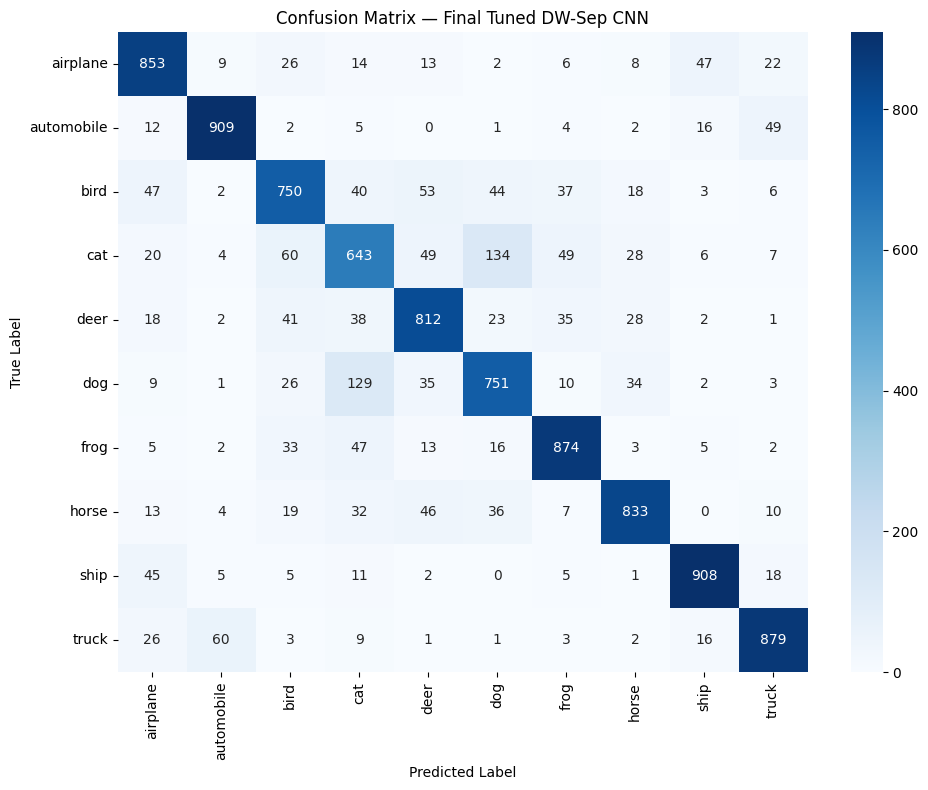

In [ ]:
# ---- Full evaluation of the final tuned model ----
final_metrics = full_evaluation(final_model, final_test_loader,
                                 "Final Tuned DW-Sep CNN")

##  Grid Search vs Optuna
Optuna reached a comparable result in fewer effective evaluations.

In [ ]:
print("\n" + "=" * 65)
print("HYPERPARAMETER TUNING — Final Comparison")
print("=" * 65)

print("\n[Grid Search Best]")
for k, v in best_grid.items():
    print(f"  {k:<15}: {v}")

print("\n[Optuna Best]")
print(f"  lr             : {study.best_params['lr']}")
print(f"  batch_size     : {study.best_params['batch_size']}")
print(f"  dropout_rate   : {study.best_params['dropout_rate']}")
print(f"  test_acc       : {study.best_value:.2f}%")

print(f"\n  Grid Search evaluated : {len(combos)} configurations (exhaustive)")
completed_trials = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
pruned_trials    = len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])
print(f"  Optuna evaluated     : {completed_trials} completed + {pruned_trials} pruned = {N_TRIALS} total")


HYPERPARAMETER TUNING — Final Comparison

[Grid Search Best]
  lr             : 0.005
  batch_size     : 128
  dropout_rate   : 0.1
  test_acc       : 77.47
  f1_score       : 77.34724135621843

[Optuna Best]
  lr             : 0.005
  batch_size     : 128
  dropout_rate   : 0.1
  test_acc       : 78.41%

  Grid Search evaluated : 27 configurations (exhaustive)
  Optuna evaluated     : 9 completed + 21 pruned = 30 total


##   Results & Discussion

A single summary.
Septhwise separable convolutions deliver a substantial reduction in parameter count and computational cost with only a modest - sometimes negligible - drop in classification accuracy on CIFAR-10.

In [ ]:
print(f"\n{'Metric':<25} {'Std CNN':>14} {'DW-Sep CNN':>14} {'Tuned DW-Sep':>14}")
print("-" * 70)
print(f"{'Parameters':<25} {std_params:>14,} {dw_params:>14,} {dw_params:>14,}")
print(f"{'Accuracy (%)':<25} {std_metrics['accuracy']:>14.2f} {dw_metrics['accuracy']:>14.2f} {final_metrics['accuracy']:>14.2f}")
print(f"{'Precision (%)':<25} {std_metrics['precision']:>14.2f} {dw_metrics['precision']:>14.2f} {final_metrics['precision']:>14.2f}")
print(f"{'Recall (%)':<25} {std_metrics['recall']:>14.2f} {dw_metrics['recall']:>14.2f} {final_metrics['recall']:>14.2f}")
print(f"{'F1-Score (%)':<25} {std_metrics['f1_score']:>14.2f} {dw_metrics['f1_score']:>14.2f} {final_metrics['f1_score']:>14.2f}")
print(f"{'Inference Time (ms)':<25} {std_time:>14.2f} {dw_time:>14.2f} {'—':>14}")
print(f"{'Param Reduction':<25} {'—':>14} {reduction:>13.2f}% {reduction:>13.2f}%")
print("-" * 70)



Metric                           Std CNN     DW-Sep CNN   Tuned DW-Sep
----------------------------------------------------------------------
Parameters                       918,826        577,226        577,226
Accuracy (%)                       86.35          79.00          82.12
Precision (%)                      86.28          78.83          82.08
Recall (%)                         86.35          79.00          82.12
F1-Score (%)                       86.30          78.87          82.09
Inference Time (ms)                 1.28           1.16              —
Param Reduction                        —         37.18%         37.18%
----------------------------------------------------------------------
